# Creating Corpus

In [1]:
import os
import zipfile
import multiprocessing

from gensim.models import word2vec
from keras.utils.data_utils import get_file

Using TensorFlow backend.


# Downloading the dataset
You can download training data and evaluation data.

In [2]:
def maybe_download(url):
    """
    Download a file if not present.
    """
    filename = url.split('/')[-1]
    path = get_file(filename, url)
    return path
    

def unzip(zip_filename):
    """
    Extract a file from the zipfile
    """
    with zipfile.ZipFile(zip_filename) as f:
        for filename in f.namelist():
            dirname = os.path.dirname(filename)
            f.extract(filename, dirname)
            return os.path.abspath(filename)
            

url = 'http://mattmahoney.net/dc/text8.zip'
filename = maybe_download(url)
text_file = unzip(filename)

# Training the Model
You can read training data from a text file using the word2vec.Text8Corpus class.
By default, it assumes that the text file is given.
Now, we obtained skip-gram model. Let's train it by calling train_on_batch and passing training examples:

In [36]:
sentences = word2vec.Text8Corpus(text_file)
window_sizes = [1, 2, 4, 8, 16]
model_names = {}
for window_size in window_sizes:
    out_model = "text8.ws{}.txt".format(window_size)
    model_names[window_size] = out_model
    if os.path.exists(out_model):
        continue
    print('Starting training with window size {}...'.format(window_size))
    model = word2vec.Word2Vec(sentences, size=200, sg=1, window=window_size, workers=multiprocessing.cpu_count())
    model.wv.save_word2vec_format(out_model)
    # model.save(out_model)
    print('Finished')
print(model_names)

{8: 'text8.ws8.txt', 1: 'text8.ws1.txt', 2: 'text8.ws2.txt', 4: 'text8.ws4.txt', 16: 'text8.ws16.txt'}


## Preparing the text data
First, we will simply iterate over the folders in which our text samples are stored, and format them into a list of samples. We will also prepare at the same time a list of class indices matching the samples:

Then we can format our text samples and labels into tensors that can be fed into a neural network. To do this, we will rely on Keras utilities keras.preprocessing.text.Tokenizer and keras.preprocessing.sequence.pad_sequences.

In [27]:
from keras.preprocessing import sequence
from keras.datasets import imdb

max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Loading word index...')
word_index = imdb.get_word_index()
print(len(word_index), 'vocabularies')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Loading data...


25000 train sequences
25000 test sequences
Loading word index...
88584

 vocabularies
Pad sequences (samples x time)


X_train shape: (25000, 80)
X_test shape: (25000, 80)


# Preparing the Embedding layer
Next, we compute an index mapping words to known embeddings, by parsing the data dump of pre-trained embeddings:

In [14]:
import numpy as np


def prepare_embeddings_index(file_path):
    """
    :param file_path: word vector's file path 
    :return embeddings_index: pre-trained word vectors
    embeddings_index = {'word1': [real numbers],
                        'word2': [real numbers],
                        ...,
                        'wordn': [real numbers]}
    """
    embeddings_index = {}
    embedding_dim = None
    with open(file_path) as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
            embedding_dim = len(coefs)
    
    print('Found %s word vectors.' % len(embeddings_index))
    return embeddings_index, embedding_dim

In [31]:
def create_embedding_matrix(embeddings_index, word_index, embedding_dim):
    #embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    embedding_matrix = np.zeros((max_features + 1, embedding_dim))
    for word, i in word_index.items():
        if i > max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# Building the Classifier

In [44]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding
from keras.layers import LSTM


def build_model(embedding_matrix, embedding_dim):
    print('Build model...')
    model = Sequential()
    model.add(Embedding(max_features + 1, output_dim=embedding_dim, weights=[embedding_matrix]))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))  # try using a GRU instead, for fun
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Training the model

In [45]:
models = {}
for window_size in sorted(model_names.keys()):
    model_name = model_names[window_size]
    embeddings_index, embedding_dim = prepare_embeddings_index(model_name)
    embedding_matrix = create_embedding_matrix(embeddings_index, word_index, embedding_dim)
    model = build_model(embedding_matrix, embedding_dim)
    print('Train...')
    model.fit(X_train, y_train, batch_size=batch_size, epochs=15, validation_data=(X_test, y_test), verbose=2)
    file_name = 'model.ws{}.h5'.format(window_size)
    models[window_size] = file_name
    model.save(file_name)

Found 71291 word vectors.
Build model...


Train...


Train on 25000 samples, validate on 25000 samples
Epoch 1/15


408s - loss: 0.5422 - acc: 0.7114 - val_loss: 0.4232 - val_acc: 0.7986
Epoch 2/15


397s - loss: 0.3075 - acc: 0.8700 - val_loss: 0.3503 - val_acc: 0.8458
Epoch 3/15


382s - loss: 0.1956 - acc: 0.9238 - val_loss: 0.4085 - val_acc: 0.8400
Epoch 4/15


400s - loss: 0.1193 - acc: 0.9573 - val_loss: 0.4820 - val_acc: 0.8346
Epoch 5/15


381s - loss: 0.0667 - acc: 0.9774 - val_loss: 0.6047 - val_acc: 0.8270
Epoch 6/15


350s - loss: 0.0423 - acc: 0.9855 - val_loss: 0.7742 - val_acc: 0.8163
Epoch 7/15


352s - loss: 0.0256 - acc: 0.9918 - val_loss: 0.8308 - val_acc: 0.8177
Epoch 8/15


350s - loss: 0.0159 - acc: 0.9955 - val_loss: 0.9854 - val_acc: 0.8166
Epoch 9/15


347s - loss: 0.0112 - acc: 0.9961 - val_loss: 1.1043 - val_acc: 0.8085
Epoch 10/15


348s - loss: 0.0085 - acc: 0.9972 - val_loss: 1.1034 - val_acc: 0.8073
Epoch 11/15


350s - loss: 0.0076 - acc: 0.9976 - val_loss: 1.1354 - val_acc: 0.8075
Epoch 12/15


359s - loss: 0.0067 - acc: 0.9978 - val_loss: 1.1329 - val_acc: 0.8102
Epoch 13/15


348s - loss: 0.0045 - acc: 0.9986 - val_loss: 1.1958 - val_acc: 0.8068
Epoch 14/15


347s - loss: 0.0048 - acc: 0.9983 - val_loss: 1.3128 - val_acc: 0.8078
Epoch 15/15


347s - loss: 0.0031 - acc: 0.9988 - val_loss: 1.4517 - val_acc: 0.8100


Found 71291 word vectors.
Build model...


Train...


Train on 25000 samples, validate on 25000 samples
Epoch 1/15


356s - loss: 0.5352 - acc: 0.7168 - val_loss: 0.3950 - val_acc: 0.8245
Epoch 2/15


352s - loss: 0.3103 - acc: 0.8683 - val_loss: 0.4027 - val_acc: 0.8250
Epoch 3/15


351s - loss: 0.1982 - acc: 0.9244 - val_loss: 0.3778 - val_acc: 0.8424
Epoch 4/15


353s - loss: 0.1218 - acc: 0.9560 - val_loss: 0.4726 - val_acc: 0.8333
Epoch 5/15


351s - loss: 0.0687 - acc: 0.9762 - val_loss: 0.6170 - val_acc: 0.8195
Epoch 6/15


352s - loss: 0.0378 - acc: 0.9873 - val_loss: 0.7633 - val_acc: 0.8213
Epoch 7/15


364s - loss: 0.0250 - acc: 0.9917 - val_loss: 0.8099 - val_acc: 0.8142
Epoch 8/15


352s - loss: 0.0163 - acc: 0.9948 - val_loss: 0.9062 - val_acc: 0.8177
Epoch 9/15


353s - loss: 0.0110 - acc: 0.9966 - val_loss: 1.1024 - val_acc: 0.8168
Epoch 10/15


351s - loss: 0.0094 - acc: 0.9968 - val_loss: 1.1238 - val_acc: 0.8130
Epoch 11/15


351s - loss: 0.0064 - acc: 0.9981 - val_loss: 1.3100 - val_acc: 0.8121
Epoch 12/15


351s - loss: 0.0055 - acc: 0.9982 - val_loss: 1.2339 - val_acc: 0.8119
Epoch 13/15


352s - loss: 0.0053 - acc: 0.9984 - val_loss: 1.2449 - val_acc: 0.8106
Epoch 14/15


351s - loss: 0.0031 - acc: 0.9993 - val_loss: 1.3267 - val_acc: 0.8121
Epoch 15/15


353s - loss: 0.0024 - acc: 0.9992 - val_loss: 1.4933 - val_acc: 0.8143


Found 71291 word vectors.
Build model...


Train...


Train on 25000 samples, validate on 25000 samples
Epoch 1/15


349s - loss: 0.5297 - acc: 0.7228 - val_loss: 0.4265 - val_acc: 0.8012
Epoch 2/15


364s - loss: 0.3074 - acc: 0.8712 - val_loss: 0.3482 - val_acc: 0.8434
Epoch 3/15


349s - loss: 0.2053 - acc: 0.9204 - val_loss: 0.3621 - val_acc: 0.8398
Epoch 4/15


346s - loss: 0.1260 - acc: 0.9543 - val_loss: 0.4884 - val_acc: 0.8314
Epoch 5/15


347s - loss: 0.0728 - acc: 0.9755 - val_loss: 0.6033 - val_acc: 0.8209
Epoch 6/15


347s - loss: 0.0448 - acc: 0.9858 - val_loss: 0.6776 - val_acc: 0.8240
Epoch 7/15


346s - loss: 0.0275 - acc: 0.9910 - val_loss: 0.8362 - val_acc: 0.8194
Epoch 8/15


347s - loss: 0.0180 - acc: 0.9945 - val_loss: 0.8720 - val_acc: 0.8169
Epoch 9/15


347s - loss: 0.0136 - acc: 0.9958 - val_loss: 0.9363 - val_acc: 0.8157
Epoch 10/15


347s - loss: 0.0100 - acc: 0.9970 - val_loss: 1.0059 - val_acc: 0.8148
Epoch 11/15


348s - loss: 0.0085 - acc: 0.9974 - val_loss: 1.1550 - val_acc: 0.8151
Epoch 12/15


347s - loss: 0.0053 - acc: 0.9983 - val_loss: 1.2865 - val_acc: 0.8156
Epoch 13/15


359s - loss: 0.0042 - acc: 0.9988 - val_loss: 1.3132 - val_acc: 0.8085
Epoch 14/15


346s - loss: 0.0070 - acc: 0.9976 - val_loss: 1.2712 - val_acc: 0.8064
Epoch 15/15


347s - loss: 0.0037 - acc: 0.9989 - val_loss: 1.3233 - val_acc: 0.8149


Found 71291 word vectors.
Build model...


Train...


Train on 25000 samples, validate on 25000 samples
Epoch 1/15


352s - loss: 0.5356 - acc: 0.7181 - val_loss: 0.4240 - val_acc: 0.8037
Epoch 2/15


345s - loss: 0.3169 - acc: 0.8664 - val_loss: 0.3465 - val_acc: 0.8493
Epoch 3/15


346s - loss: 0.2070 - acc: 0.9196 - val_loss: 0.4196 - val_acc: 0.8354
Epoch 4/15


345s - loss: 0.1302 - acc: 0.9532 - val_loss: 0.4526 - val_acc: 0.8316
Epoch 5/15


346s - loss: 0.0752 - acc: 0.9741 - val_loss: 0.5945 - val_acc: 0.8214
Epoch 6/15


345s - loss: 0.0437 - acc: 0.9858 - val_loss: 0.6866 - val_acc: 0.8231
Epoch 7/15


345s - loss: 0.0275 - acc: 0.9909 - val_loss: 0.8483 - val_acc: 0.8179
Epoch 8/15


358s - loss: 0.0214 - acc: 0.9936 - val_loss: 0.9130 - val_acc: 0.8190
Epoch 9/15


346s - loss: 0.0140 - acc: 0.9961 - val_loss: 0.9454 - val_acc: 0.8198
Epoch 10/15


347s - loss: 0.0101 - acc: 0.9967 - val_loss: 1.0090 - val_acc: 0.8210
Epoch 11/15


346s - loss: 0.0090 - acc: 0.9972 - val_loss: 1.1599 - val_acc: 0.8122
Epoch 12/15


346s - loss: 0.0052 - acc: 0.9980 - val_loss: 1.2382 - val_acc: 0.8156
Epoch 13/15


346s - loss: 0.0064 - acc: 0.9981 - val_loss: 1.1135 - val_acc: 0.8140
Epoch 14/15


345s - loss: 0.0058 - acc: 0.9984 - val_loss: 1.2722 - val_acc: 0.8131
Epoch 15/15


347s - loss: 0.0042 - acc: 0.9986 - val_loss: 1.2518 - val_acc: 0.8090


Found 71291 word vectors.
Build model...


Train...


Train on 25000 samples, validate on 25000 samples
Epoch 1/15


353s - loss: 0.5211 - acc: 0.7294 - val_loss: 0.4042 - val_acc: 0.8277
Epoch 2/15


350s - loss: 0.3152 - acc: 0.8678 - val_loss: 0.3548 - val_acc: 0.8420
Epoch 3/15


370s - loss: 0.2054 - acc: 0.9212 - val_loss: 0.4173 - val_acc: 0.8333
Epoch 4/15


350s - loss: 0.1280 - acc: 0.9534 - val_loss: 0.4765 - val_acc: 0.8294
Epoch 5/15


350s - loss: 0.0747 - acc: 0.9743 - val_loss: 0.5825 - val_acc: 0.8258
Epoch 6/15


352s - loss: 0.0449 - acc: 0.9844 - val_loss: 0.7973 - val_acc: 0.8182
Epoch 7/15


350s - loss: 0.0245 - acc: 0.9921 - val_loss: 0.8499 - val_acc: 0.8190
Epoch 8/15


350s - loss: 0.0180 - acc: 0.9944 - val_loss: 0.9635 - val_acc: 0.8145
Epoch 9/15


350s - loss: 0.0125 - acc: 0.9966 - val_loss: 1.1059 - val_acc: 0.8185
Epoch 10/15


351s - loss: 0.0102 - acc: 0.9963 - val_loss: 1.0571 - val_acc: 0.8150
Epoch 11/15


350s - loss: 0.0099 - acc: 0.9969 - val_loss: 1.0845 - val_acc: 0.8130
Epoch 12/15


351s - loss: 0.0067 - acc: 0.9980 - val_loss: 1.2109 - val_acc: 0.8100
Epoch 13/15


359s - loss: 0.0055 - acc: 0.9982 - val_loss: 1.2109 - val_acc: 0.8121
Epoch 14/15


351s - loss: 0.0046 - acc: 0.9987 - val_loss: 1.2434 - val_acc: 0.8116
Epoch 15/15


351s - loss: 0.0055 - acc: 0.9984 - val_loss: 1.2726 - val_acc: 0.8105


# Evaluation
## Evaluation of Classifier

In [53]:
from keras.models import load_model

accuracies = []
for window_size in window_sizes:
    file_name = models[window_size]
    model = load_model(file_name)
    score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)
    accuracies.append(acc)
    print('Test score:', score)
    print('Test accuracy:', acc)

Test score: 1.45166337306
Test accuracy: 0.81


Test score: 1.49326546386
Test accuracy: 0.81432


Test score: 1.32333767938
Test accuracy: 0.81492


Test score: 1.25181883136
Test accuracy: 0.80896


Test score: 1.27263815701
Test accuracy: 0.81052


## Evaluation of Word Embeddings

In [57]:
import gensim.test
from gensim.models import KeyedVectors
module_path = gensim.test.__path__[0]
spearmans = []
for window_size in window_sizes:
    model_name = model_names[window_size]
    word_vectors = KeyedVectors.load_word2vec_format(model_name)
    _, spearman, _ = word_vectors.evaluate_word_pairs(os.path.join(module_path, 'test_data', 'simlex999.txt'))
    spearmans.append(spearman.correlation)
    print(spearman.correlation)

0.292760902576


0.310061952976


0.325393257579


0.323752469637


0.315730612279


## Plotting the evaluation result

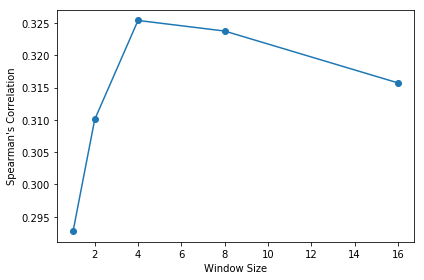

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(window_sizes, spearmans, marker='o')
plt.xlabel('Window Size')
plt.ylabel('Spearman\'s Correlation')

plt.tight_layout()
plt.show()

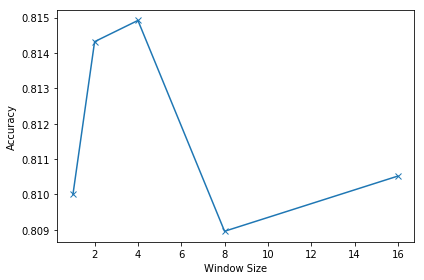

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
accuracies1 = [0.1735, 0.1735, 0.2091, 0.1453, 0.1560]
plt.plot(window_sizes, accuracies, marker='x')
plt.xlabel('Window Size')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Result